In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##### basic matrix multiplication - just to make sure shapes are right

In [3]:
previous_position = np.array([0.5,0.75,1.25,1.5]).reshape(-1,1)
binomial_moves = np.array([50,-50]).reshape(-1,1)
previous_pnl = np.array([87.5,12.5,12.5,-112.5]).reshape(-1,1)

In [4]:
print(np.shape(previous_position),np.shape(binomial_moves),np.shape(previous_pnl))

(4, 1) (2, 1) (4, 1)


In [5]:
(np.dot(previous_position,np.transpose(binomial_moves)) + previous_pnl)

array([[ 112.5,   62.5],
       [  50. ,  -25. ],
       [  75. ,  -50. ],
       [ -37.5, -187.5]])

In [6]:
next_pnl = (np.dot(previous_position,np.transpose(binomial_moves)) + previous_pnl).reshape(-1,1)

In [7]:
next_pnl

array([[ 112.5],
       [  62.5],
       [  50. ],
       [ -25. ],
       [  75. ],
       [ -50. ],
       [ -37.5],
       [-187.5]])

## builder functions

In [8]:
def current_pnl(previous_position,binomial_moves,previous_pnl):
    previous_position = previous_position.reshape(-1,1)
    binomial_moves = binomial_moves.reshape(-1,1)
    previous_pnl = previous_pnl.reshape(-1,1)
    
    return (np.dot(previous_position,np.transpose(binomial_moves)) + previous_pnl).reshape(-1,1)

In [9]:
def current_position(previous_position,buy_size,sell_size):
    lot_size = np.array([-sell_size,buy_size]).reshape(-1,1)
    previous_position = previous_position.reshape(-1,1)
    return (previous_position + np.transpose(lot_size)).reshape(-1,1)


In [10]:
previous_position = np.array([0.75,1.25]).reshape(-1,1)
buy_size = 0.25
sell_size = 0.25

In [11]:
current_position(previous_position,buy_size,sell_size)

array([[0.5],
       [1. ],
       [1. ],
       [1.5]])

In [12]:
def time_step(previous_position,binomial_moves,previous_pnl,buy_size,sell_size):
    return current_position(previous_position,buy_size,sell_size),current_pnl(previous_position,binomial_moves,previous_pnl)

## without increasing position sizing

In [13]:
t = 3 # number of time steps
starting_bet = 1000000
previous_pnl = np.array([0])
previous_position = np.array([starting_bet])
buy_size = 250000
sell_size = 250000
binomial_moves = np.array([50,-50]).reshape(-1,1)/10000

In [14]:
def expand_array(arr, num_copies):
    # Repeat the array side by side for user-defined times
    duplicated_arr = np.tile(arr, (1, num_copies))
    # Flatten the array
    vertical_arr = duplicated_arr.reshape(-1,1)
    return vertical_arr


In [15]:
def binomial_tree(previous_position,binomial_moves,previous_pnl,buy_size,sell_size,t):
    pnl_df = pd.DataFrame(np.zeros((2**t,t)),columns = list(['pnl'+str(i+1) for i in range(0,t)]))
    position_df = pd.DataFrame(np.zeros((2**t,t)),columns = list(['position'+str(i) for i in range(0,t)]))
    for i in range (0,t):
        cur_pos = previous_position
        previous_position,previous_pnl = time_step(cur_pos,binomial_moves,previous_pnl,buy_size,sell_size)
        pnl_df.iloc[:,i] = expand_array(previous_pnl, int(2**t/len(previous_pnl)))
        position_df.iloc[:,i] = expand_array(cur_pos, int(2**t/len(cur_pos)))
    return  pnl_df,position_df


In [16]:
pnl,position=binomial_tree(previous_position,binomial_moves,previous_pnl,buy_size,sell_size,t)

In [17]:
def plot_tables(pnl,position):
    """Plot the PnL and Position tables"""
    # PnL Table
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('tight')
    pnl_table = ax.table(cellText=pnl.values, colLabels=['pnl_' + str(i+1) for i in range(pnl.shape[1])], 
                        rowLabels=[str(i+1) for i in range(pnl.shape[0])], loc='center')
    pnl_table.auto_set_font_size(False)
    pnl_table.set_fontsize(10)
    plt.show()

    # Position Table
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('tight')
    position_table = ax.table(cellText=position.values, colLabels=['position_' + str(i+1) for i in range(position.shape[1])], 
                        rowLabels=[str(i+1) for i in range(position.shape[0])], loc='center')
    position_table.auto_set_font_size(False)
    position_table.set_fontsize(10)
    plt.show()


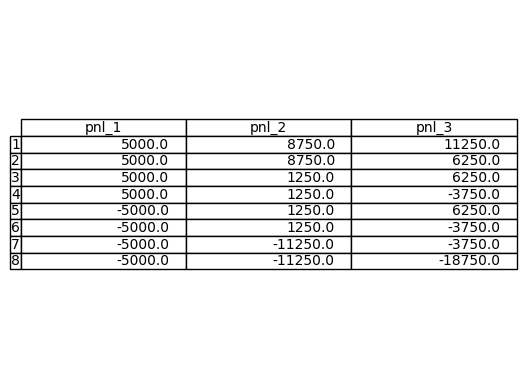

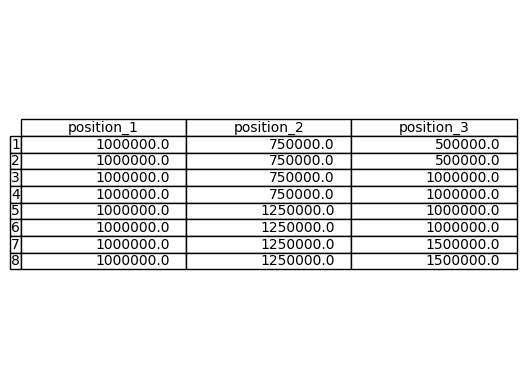

In [18]:
plot_tables(pnl,position)

In [19]:
def calc_expected(previous_pnl):
    value = np.sum(previous_pnl)/len(previous_pnl)
    print('expected value:-',value)

def calc_pop(previous_pnl):
    profit = np.where(previous_pnl>=0,1,0)
    pop = np.sum(profit)/len(profit)*100
    print('probability of profit:-',pop,'%')
    return pop

In [20]:
last_pnl = pnl.iloc[:,-1]
calc_expected(last_pnl)
calc_pop(last_pnl)

expected value:- 0.0
probability of profit:- 50.0 %


50.0

we see if we just buy and sell the same amount we get expected value of 0. we also have a probability of profit of 50 %

## While increasing position sizing

In [21]:
t = 3
starting_bet = 1000000
previous_pnl = np.array([0])
previous_position = np.array([starting_bet])
buy_size = 250000
sell_size = 250000
binomial_moves = np.array([50,-50]).reshape(-1,1)/10000

bet_increase_ratio = 5 # we set it as 5 to correspond with your example - postion size at time 2 or t=1 is 1.25M whereas at t=0 it is 0.25M. 
# keep in mind it will continue to increase for later time steps to solve this change i>= 1 to i==1 in the if statement below

In [22]:
def biased_binomial_tree(previous_position,binomial_moves,previous_pnl,buy_size,sell_size,t,bet_increase_ratio):
    pnl_df = pd.DataFrame(np.zeros((2**t,t)),columns = list(['pnl'+str(i+1) for i in range(0,t)]))
    position_df = pd.DataFrame(np.zeros((2**t,t)),columns = list(['position'+str(i) for i in range(0,t)]))
    for i in range (0,t):
        if i>=1:  # increase bet size after first time step
            buy_size = buy_size * bet_increase_ratio # we increase every subsequent time step but not relistic as we dont have infinite money
            #sell_size = sell_size*bet_increase_ratio - uncomment if we have a bearish outlook ahead and comment out above line.
        cur_pos = previous_position
        previous_position,previous_pnl = time_step(cur_pos,binomial_moves,previous_pnl,buy_size,sell_size)
        pnl_df.iloc[:,i] = expand_array(previous_pnl, int(2**t/len(previous_pnl)))
        position_df.iloc[:,i] = expand_array(cur_pos, int(2**t/len(cur_pos)))
    return pnl_df,position_df

In [23]:
pnl,position=biased_binomial_tree(previous_position,binomial_moves,previous_pnl,buy_size,sell_size,t,bet_increase_ratio)

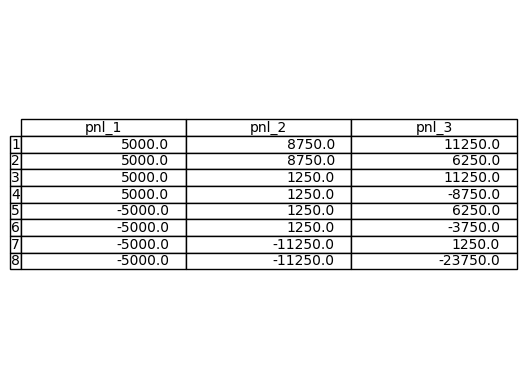

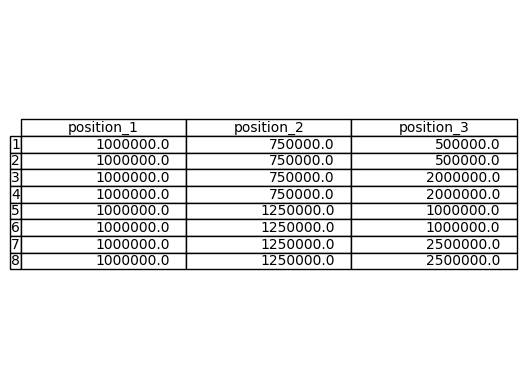

In [24]:
plot_tables(pnl,position)

In [25]:
last_pnl = pnl.iloc[:,-1]
calc_expected(last_pnl)
calc_pop(last_pnl)

expected value:- 0.0
probability of profit:- 62.5 %


62.5

### Evolution of PoP vs time

In [101]:
starting_bet = 1000000
previous_pnl = np.array([0])
previous_position = np.array([starting_bet])
buy_size = 250000
sell_size = 250000
binomial_moves = np.array([0.005,-0.004]).reshape(-1,1)
max_t = 15
bet_increase_ratio = 4 # we set it as 5 to correspond with your example - postion size at time 2 or t=1 is 1.25M whereas at t=0 it is 0.25M. 
# keep in mind it will continue to increase for later time steps to solve this change i>= 1 to i==1 in the if statement below

In [102]:
pop_list = []
for t in np.arange(1,max_t,1):
    pnl,position=biased_binomial_tree(previous_position,binomial_moves,previous_pnl,buy_size,sell_size,t,bet_increase_ratio)
    last_pnl = pnl.iloc[:,-1]
    final_pnl = last_pnl
    pop_list.append(calc_pop(final_pnl))

probability of profit:- 50.0 %
probability of profit:- 75.0 %
probability of profit:- 62.5 %
probability of profit:- 68.75 %
probability of profit:- 71.875 %
probability of profit:- 71.875 %
probability of profit:- 71.875 %
probability of profit:- 71.875 %
probability of profit:- 71.875 %
probability of profit:- 71.77734375 %
probability of profit:- 71.77734375 %
probability of profit:- 71.8017578125 %
probability of profit:- 71.83837890625 %
probability of profit:- 71.8505859375 %


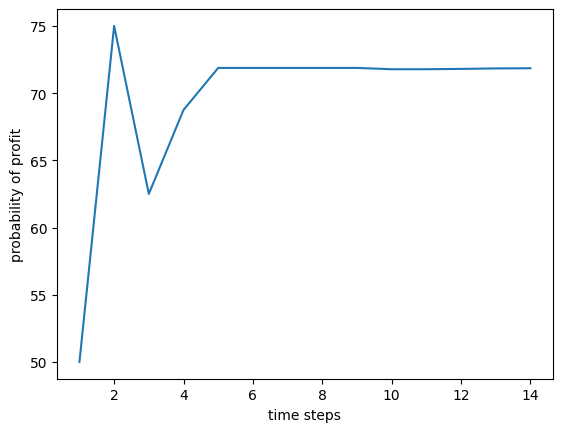

In [103]:
plt.plot(np.arange(1,max_t,1),pop_list)
plt.ylabel('probability of profit')
plt.xlabel('time steps')
plt.show()

In [94]:
np.min(final_pnl)

-147000.0

In [35]:
def pop_vs_time(starting_position=1000000,initial_buy_size=250000,initial_sell_size=250000,max_t = 3,move_size = 0.005,bet_increase_ratio=5,plot_chart = True):
    previous_pnl = np.array([0])
    previous_position = np.array([starting_position])
    buy_size = initial_buy_size
    sell_size = initial_sell_size
    binomial_moves = np.array([move_size,-move_size]).reshape(-1,1)
    pop_list = []
    for t in np.arange(1,max_t,1):
        pnl,position=biased_binomial_tree(previous_position,binomial_moves,previous_pnl,buy_size,sell_size,t,bet_increase_ratio)
        last_pnl = pnl.iloc[:,-1]
        final_pnl = last_pnl
        pop_list.append(calc_pop(final_pnl))
    if plot_chart:
        plt.plot(np.arange(1,max_t,1),pop_list)
        plt.ylabel('probability of profit')
        plt.xlabel('time steps')
        plt.show()
    return pop_list

probability of profit:- 50.0 %
probability of profit:- 75.0 %
probability of profit:- 50.0 %
probability of profit:- 68.75 %
probability of profit:- 50.0 %
probability of profit:- 65.625 %
probability of profit:- 50.0 %
probability of profit:- 63.671875 %
probability of profit:- 50.0 %
probability of profit:- 62.3046875 %
probability of profit:- 72.55859375 %
probability of profit:- 61.2548828125 %
probability of profit:- 70.93505859375 %
probability of profit:- 60.382080078125 %
probability of profit:- 69.5892333984375 %
probability of profit:- 59.6099853515625 %
probability of profit:- 68.4295654296875 %
probability of profit:- 58.896636962890625 %
probability of profit:- 67.39845275878906 %


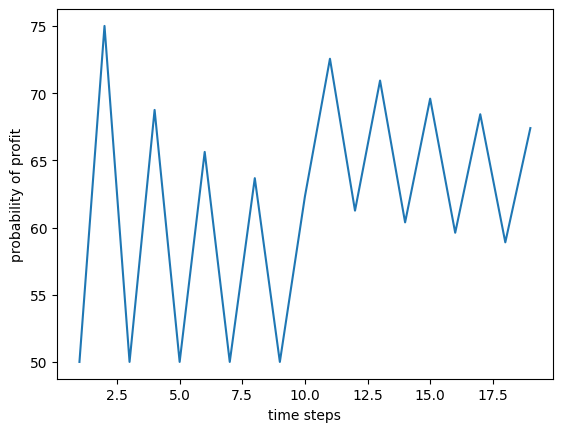

[50.0,
 75.0,
 50.0,
 68.75,
 50.0,
 65.625,
 50.0,
 63.671875,
 50.0,
 62.3046875,
 72.55859375,
 61.2548828125,
 70.93505859375,
 60.382080078125,
 69.5892333984375,
 59.6099853515625,
 68.4295654296875,
 58.896636962890625,
 67.39845275878906]

In [36]:
pop_vs_time(starting_position=1000000,initial_buy_size=200000,initial_sell_size=200000,max_t = 20,move_size = 0.005,bet_increase_ratio=1,plot_chart = True)

In [37]:
powers = np.arange(-10,3,1.0)
ratio_list = [1 + 2**i for i in powers]